# DIY Covid-19 Dashboard

I built this project as an interactive COVID-19 dashboard using Jupyter Notebook, pandas, matplotlib, ipywidgets, and the official Public Health England COVID-19 API. The dashboard first loads pre-processed (“canned”) hospital data from a local JSON file, which I structured into a clean pandas DataFrame before visualising it. Users can then fetch the latest data from the API through a refresh button, which updates the underlying dataset and regenerates the graph.

The dashboard presents a time-series comparison between new hospital admissions and ventilator bed occupancy in England. Interactive widgets such as a dropdown menu and a scale selector allow users to explore different views of the data.

The notebook is deployed using Voila, which converts it into a clean, code-free interactive dashboard. Voila operates at the notebook-server level, so it does not need to be imported inside the notebook; instead, it executes the code in the background and updates all visualisations and widgets in response to user interactions.

In [6]:
from IPython.display import clear_output
import ipywidgets as wdg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from uk_covid19 import Cov19API

In [7]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

## Load initial data from disk

I include "canned" data in ```.json``` files along with the dashboard. When the dashboard starts, it loads that data and assign it as a dictionary to the ```jsondata``` variable (the code below will be hidden when the dashboard is rendered by Voila).

In [8]:
# Load JSON files and store the raw data in some variable. Edit as appropriate
# Show A Comparison of Hospital Admissions with Ventilator Bed Occupancy in England
import json
with open("hosptial.json", "r") as json_file:
    jsondata = json.load(json_file)

## Wrangle the data

The dashboard contains the logic to wrangle the raw data into a ```DataFrame``` (or more than one, as required) that will be used for plotting. The wrangling code be put into a function and called on the data from the JSON file (we'll need to call it again on any data downloaded from the API).  In this template, I just pretend we are wrangling ```rawdata``` and instead generate a dataframe with some random data

In [9]:
import pandas as pd
import numpy as np
def wrangle_data(rawdata):
    """ Parameters: rawdata - data from json file or API call. Returns a dataframe. """
    
    datalist = rawdata['data']
    dates = [dictionary['date'] for dictionary in datalist]
    dates.sort()

    def parse_date(datestring):
        return pd.to_datetime(datestring, format="%Y-%m-%d")

    startdate = parse_date(dates[0])
    enddate = parse_date(dates[-1])

    index = pd.date_range(startdate, enddate, freq='D')
    hospitaldf = pd.DataFrame(index=index, columns=['newAdmissions', 'covidOccupiedMVBeds'])

    for entry in datalist:
        date = parse_date(entry['date'])
        for column in ['newAdmissions', 'covidOccupiedMVBeds']:
            if pd.isna(hospitaldf.loc[date, column]):
                value = float(entry[column]) if entry[column] != None else 0.0
                hospitaldf.loc[date, column] = value

    hospitaldf.fillna(0.0, inplace=True)

    return hospitaldf

# call wrangle_data to df
df = wrangle_data(jsondata)

## Download current data

I give users an option to refresh the dataset through a “refresh” button. The button callback:

* calls the code that accesses the API and downloads fresh raw data;
* wrangles that data into a dataframe and updates the corresponding global variable used for plotting (in this case, `df`);
* optionally forces a redraw of the graph and provides some feedback to the user.

Once this works, I may wrap the API call inside an exception handler, so that users are informed if something goes wrong, the “canned” data are not overwritten, and nothing crashes if the server cannot be reached or data are unavailable.

After the data is refreshed, the graph will not update until the user interacts with a widget. I can trigger an update in `ipywidgets` by simulating interaction, as shown in the `refresh_graph` function defined in the Graph and Analysis section.

In my implementation, clicking the button generates fresh data from the API and refreshes the graph. The button is labelled *Fetch Data*. If anything unexpected appears, take a deep breath :)

In [10]:
# Place your API access code in this function. Do not call this function directly; it will be called by 
# the button callback. 
def access_api():
    """ Accesses the PHE API. Return data as a like-for-like replacement for the "canned" data loaded from the JSON file. """
    

    from uk_covid19 import Cov19API
    import json

    filters = [
        'areaType=nation',
        'areaName=England'
    ]

    structure = {
        "date": "date",
        "newAdmissions": "newAdmissions",
        "covidOccupiedMVBeds": "covidOccupiedMVBeds"
    }

    api = Cov19API(filters=filters, structure=structure)
    hosptital = api.get_json()

    return hosptital

In [11]:
# Printout from this function will be lost in Voila unless captured in an
# output widget - therefore, we give feedback to the user by changing the 
# appearance of the button
def api_button_callback(button):
    """ Button callback - it must take the button as its parameter (unused in this case).
    Accesses API, wrangles data, updates global variable df used for plotting. """
    # Get fresh data from the API. If you have time, include some error handling
    # around this call.
    apidata=access_api()
    # wrangle the data and overwrite the dataframe for plotting
    global df
    df=wrangle_data(apidata)
    # the graph won't refresh until the user interacts with the widget.
    # this function simulates the interaction, see Graph and Analysis below.
    # The function needs to be adapted to your graph; you can omit this call
    # in the first instance
    refresh_graph()
    # after all is done, you can switch the icon on the button to a "check" sign
    # and optionally disable the button - it won't be needed again. If you are 
    # implementing error handling, you can use icons "unlink" or "times" and 
    # change the button text to "Unavailable" when the api call fails.
    apibutton.icon="check"
    # apibutton.disabled=True

    
apibutton=wdg.Button(
    description='Refresh data', # you may want to change this...
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Keep calm and carry on",
    # FontAwesome names without the `fa-` prefix - try "download"
    icon='exclamation-triangle'
)

# remember to register your button callback function with the button
apibutton.on_click(api_button_callback) # the name of your function inside these brackets

display(apibutton)

# run all cells before clicking on this button

Button(button_style='danger', description='Refresh data', icon='exclamation-triangle', style=ButtonStyle(), to…

## Graphs and Analysis

Include at least one graph with interactive controls, as well as some instructions for the user and/or comments on what the graph represents and how it should be explored (this example shows two random walks)

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as wdg

def plot_random_walk(walk, scale):
    """ Our sample graph plotting function """
    if scale == 'linear':
        df[walk].plot()
    else:
        df[walk].plot(logy=True)
    plt.show()  # important! update won't work properly without this

# a sample widget
whichwalk = wdg.Dropdown(
    options=['newAdmissions', 'covidOccupiedMVBeds'], 
    value='newAdmissions',
    description='Walk no: ',
    disabled=False,
)

# Add a scale selection widget
scale = wdg.RadioButtons(
    options=['linear', 'log'],
    value='linear',
    description='Scale: ',
    disabled=False,
)

def refresh_graph():
    """ We change the value of the widget to force a redraw of the graph;
    this is useful when the data have been updated. This is a bit of a gimmick; it
    needs to be customised for one of your widgets. """
    current = whichwalk.value
    if current == whichwalk.options[0]:
        other = whichwalk.options[1]
    else:
        other = whichwalk.options[0]
    whichwalk.value = other  # forces the redraw
    whichwalk.value = current  # now we can change it back

# connect the plotting function and the widgets
graph = wdg.interactive_output(plot_random_walk, {'walk': whichwalk, 'scale': scale})

# actually display the widgets and the graph
display(whichwalk, scale, graph)

Dropdown(description='Walk no: ', options=('newAdmissions', 'covidOccupiedMVBeds'), value='newAdmissions')

RadioButtons(description='Scale: ', options=('linear', 'log'), value='linear')

Output()

## Deploying the dashboard

Once I was satisfied with the code and the appearance of the graphs, I replaced the placeholder text in the notebook with explanations intended for end users of the dashboard. The next step was to deploy the dashboard online. I chose to use Binder for deployment, as it provides a simple and reproducible way to run the notebook, its environment, and the Voila interface directly in the browser without requiring users to install anything locally.

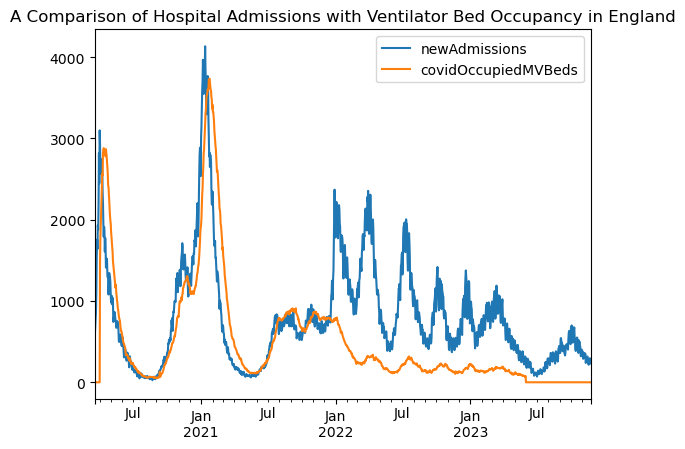

In [ ]:
#here is the overall graph to show a comparion of  Hospital Admissions with Ventilator Bed Occupancy
df = wrangle_data(jsondata)
df.plot()
plt.title('A Comparison of Hospital Admissions with Ventilator Bed Occupancy in England')
plt.show()

**Author:** Dashboard created by Linda Lin, 2023.

**Data Source:**  
COVID-19 data retrieved from the UK Government COVID-19 API  
(https://coronavirus.data.gov.uk/), published by Public Health England.